Import Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score

Begin Data Cleaning

In [2]:
# read file
df = pd.read_csv(r'C:\Users\krist\Downloads\SN_y_tot_V2.0.csv', sep=';')

In [3]:
# inspect data
df.head()

,1700.5,8.3,-1.0,-1,1
0,1701.5,18.3,-1.0,-1,1
1,1702.5,26.7,-1.0,-1,1
2,1703.5,38.3,-1.0,-1,1
3,1704.5,60.0,-1.0,-1,1
4,1705.5,96.7,-1.0,-1,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1700.5  321 non-null    float64
 1      8.3  321 non-null    float64
 2    -1.0   321 non-null    float64
 3       -1  321 non-null    int64  
 4   1       321 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 12.7 KB


In [5]:
# check for duplicated rows
df[df.duplicated()]

,1700.5,8.3,-1.0,-1,1


In [6]:
# check for missing values
df.isna().sum()

1700.5    0
   8.3    0
 -1.0     0
    -1    0
1         0
dtype: int64

In [7]:
# clean column names
df.columns = df.columns.str.strip()
print(df.columns)

Index(['1700.5', '8.3', '-1.0', '-1', '1'], dtype='object')


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1700.5  321 non-null    float64
 1   8.3     321 non-null    float64
 2   -1.0    321 non-null    float64
 3   -1      321 non-null    int64  
 4   1       321 non-null    int64  
dtypes: float64(3), int64(2)
memory usage: 12.7 KB


Prepare Data for Prophet

In [9]:
# convert Year into Date column (ds for Prophet)
df['Date'] = pd.to_datetime(df['1700.5'].astype(int), format='%Y')

In [10]:
# prepare data 
df_prophet = df[['Date', '8.3']].rename(columns={'Date': 'ds', '8.3': 'y'})

In [11]:
# rename columns for prophet
df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
df_prophet['y'] = pd.to_numeric(df_prophet['y'], errors='coerce')

In [12]:
print(df_prophet.head())

          ds     y
0 1701-01-01  18.3
1 1702-01-01  26.7
2 1703-01-01  38.3
3 1704-01-01  60.0
4 1705-01-01  96.7


Once again, the first row is lost, but it is such a small percentage of the data that I don't think it will affect my outcome much.

Fit Model

In [13]:
# split data
train_size = int(len(df_prophet) * 0.8)
df_train = df_prophet[:train_size]
df_test = df_prophet[train_size:]

In [14]:
# make list for periods and frequencies
periods_list = [1, 10, 20]
freq_list = ['YE', 'YE', 'YE']

In [15]:
# define function for forecasts
def forecast_sunspots(df_train, periods_list, freq_list):
    forecasts = {}
    # initialize and fit model
    model = Prophet()
    model.fit(df_train)
    # loop through periods and frequencies to generate forecasts
    for period, freq in zip(periods_list, freq_list):
        future = model.make_future_dataframe(periods=period, freq=freq)
        forecast = model.predict(future)
        forecast_future = forecast[forecast['ds'] > df_train['ds'].max()]
        forecasts[period] = forecast_future
    return forecasts

In [16]:
print(df_prophet.columns)

Index(['ds', 'y'], dtype='object')


In [17]:
# call functions for different periods
forecasts = forecast_sunspots(df_train, periods_list, freq_list)

15:12:49 - cmdstanpy - INFO - Chain [1] start processing
15:12:49 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
print(forecasts)

{1:             ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
256 1956-12-31  117.562259   -7.049292  145.060894   117.562259   117.562259   

     additive_terms  additive_terms_lower  additive_terms_upper     yearly  \
256      -48.048891            -48.048891            -48.048891 -48.048891   

     yearly_lower  yearly_upper  multiplicative_terms  \
256    -48.048891    -48.048891                   0.0   

     multiplicative_terms_lower  multiplicative_terms_upper       yhat  
256                         0.0                         0.0  69.513368  , 10:             ds       trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
256 1956-12-31  117.562259   -5.819113  137.848548   117.562259   117.562259   
257 1957-12-31  117.943266  -18.982674  140.574426   117.943266   117.943266   
258 1958-12-31  118.324273  -23.575337  126.509002   118.324273   118.324273   
259 1959-12-31  118.705280  -23.045866  116.421652   118.705280   118.705280   
260 1960-12-

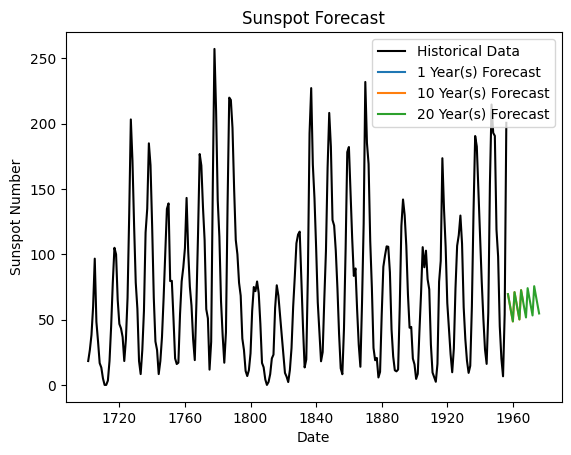

In [19]:
# plot both the historical data and the forecasts on one graph
# historical data
plt.plot(df_train['ds'], df_train['y'], label='Historical Data', color='black')
# loop forecasts
for period, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{period} Year(s) Forecast')
# plot forecasts
plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Forecast')
plt.legend()
# show the plot
plt.show()

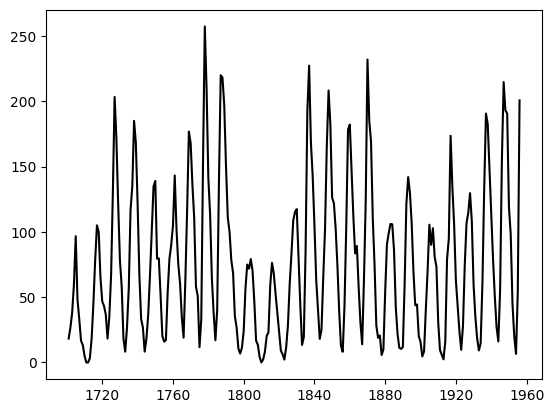

In [20]:
# plot historical data alone for comparison
plt.plot(df_train['ds'], df_train['y'], label='Historical Data', color='black')

In [21]:
# ensure that the forecasts are correctly formatted
for period, forecast in forecasts.items():
    print(f"Forecast for {period} year(s):")
    print(forecast[['ds', 'yhat']].head()) 

Forecast for 1 year(s):
            ds       yhat
256 1956-12-31  69.513368
Forecast for 10 year(s):
            ds       yhat
256 1956-12-31  69.513368
257 1957-12-31  62.470313
258 1958-12-31  55.502909
259 1959-12-31  48.619992
260 1960-12-31  71.038440
Forecast for 20 year(s):
            ds       yhat
256 1956-12-31  69.513368
257 1957-12-31  62.470313
258 1958-12-31  55.502909
259 1959-12-31  48.619992
260 1960-12-31  71.038440


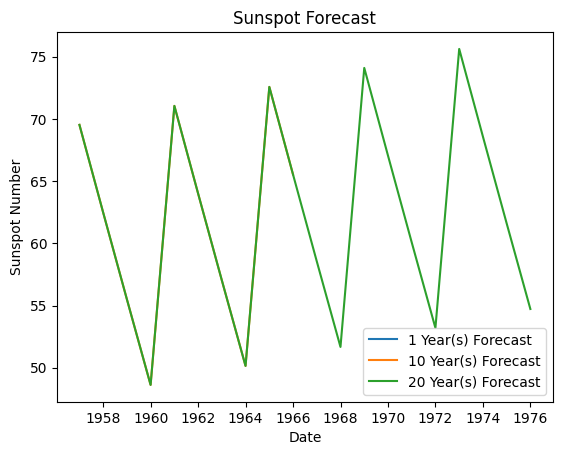

In [22]:
# plot forecasts for the three different periods
for period, forecast in forecasts.items():
    plt.plot(forecast['ds'], forecast['yhat'], label=f'{period} Year(s) Forecast')

plt.xlabel('Date')
plt.ylabel('Sunspot Number')
plt.title('Sunspot Forecast')
plt.legend()
plt.show()

Once again, I will plot them separately to make sure they are all there.

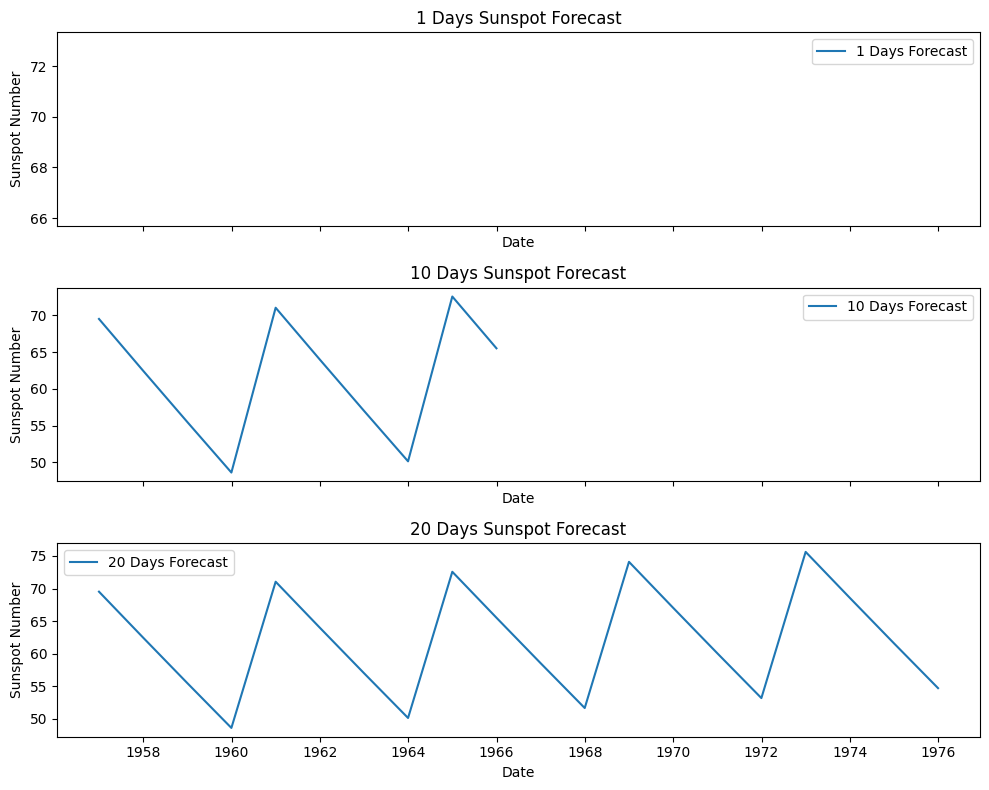

In [23]:
# create subplots
fig, axes = plt.subplots(len(forecasts), 1, figsize=(10, 8), sharex=True)

# plot each forecast in a different subplot
for ax, (period, forecast) in zip(axes, forecasts.items()):
    ax.plot(forecast['ds'], forecast['yhat'], label=f'{period} Days Forecast')
    ax.set_title(f'{period} Days Sunspot Forecast')
    ax.set_xlabel('Date')
    ax.set_ylabel('Sunspot Number')
    ax.legend()

# adjust the layout to avoid overlap
plt.tight_layout()
plt.show()

This forecast is interesting to me because while it is still fluctuating, it also is steadily increasing over time. Like the daily and monthly forecast, the range of the forecast seems to be a little low compared to the historical data. Also, the 1 year forecast doesn't seem to show, presumably becuase there is only one datapoint.

Evaluate Model

In [24]:
# standardize both dataframes since there was a slight mismatch in date format
df_prophet['ds'] = pd.to_datetime(df_prophet['ds']).dt.to_period('Y').dt.start_time
forecast['ds'] = pd.to_datetime(forecast['ds']).dt.to_period('Y').dt.start_time

In [25]:
# merge actual data and forecast
df_comparison = pd.merge(forecast[['ds', 'yhat']], df_prophet[['ds','y']], on='ds', how='inner')

In [26]:
print(df_comparison.head())

          ds       yhat      y
0 1956-01-01  69.513368  200.7
1 1957-01-01  62.470313  269.3
2 1958-01-01  55.502909  261.7
3 1959-01-01  48.619992  225.1
4 1960-01-01  71.038440  159.0


In [27]:
# calculate MAE, MAPE, and R^2
mae = mean_absolute_error(df_comparison['y'], df_comparison['yhat'])
mape = mean_absolute_percentage_error(df_comparison['y'], df_comparison['yhat'])
r2 = r2_score(df_comparison['y'], df_comparison['yhat'])

In [28]:
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

MAE: 69.69831973146044
MAPE: 0.7424524320145582
R²: -0.4812227754273586


As predicted, my MAE was quite high since my predicted values seem to be low compared to the actual values. My MAPE is considered pretty good which is great to see, but my R^2 is negative again, so that is not a great sign. Hopefully these numbers will improve a bit after the parameter tuning. 

Tune the Model on Different Parameters

Forecasting Growth

Once again, I will be using logistic growth because the data is fluctuating over time and there seems to be a cap. I chose my cap to be 300 since the maximum value in the historical data seems to be a little over 250. I also reduced the data again, since the forecasts were taking a very long time to run.

In [29]:
# reduce data
df_train_subset = df_train.tail(50)

In [30]:
# create capacity column (upper limit)
df_train_subset['cap'] = 300

C:\Users\krist\AppData\Local\Temp\ipykernel_27836\1993053658.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_subset['cap'] = 300


In [31]:
# tune parameter
model = Prophet(growth='logistic')
model.fit(df_train_subset)

15:12:52 - cmdstanpy - INFO - Chain [1] start processing
15:12:52 - cmdstanpy - INFO - Chain [1] done processing


In [32]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=20)

In [33]:
# add cap column
future['cap'] = 300

In [34]:
# make forecast
forecast = model.predict(future)

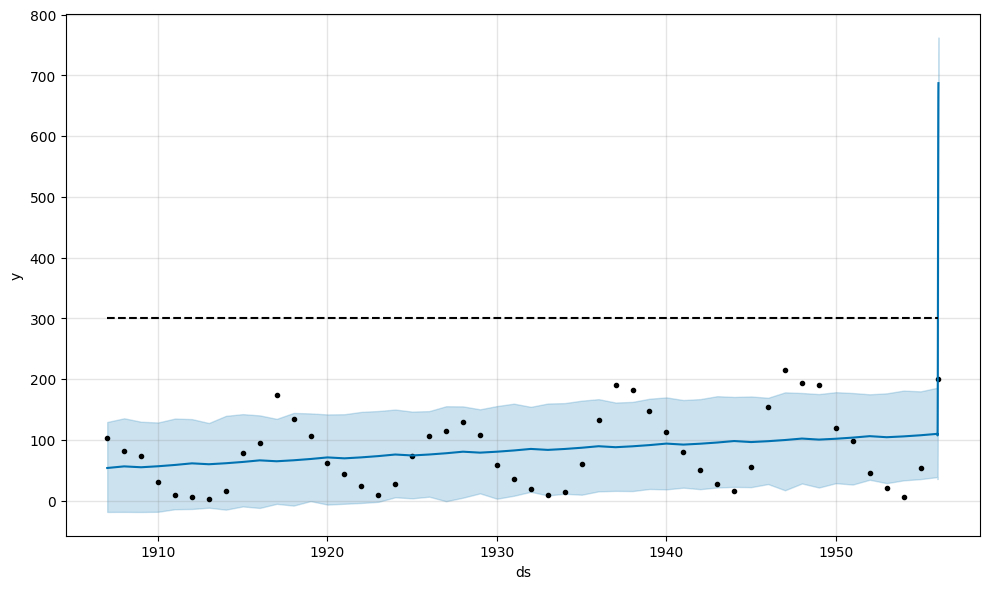

In [35]:
# plot
model.plot(forecast)
plt.show()

By the look of the graph, it seems to shoot up at the end to try to balance out the undershot predicted values. I think it may be misleading, like the monthly forecast, and I will see how it truly fairs when I see the final error rates.

Seasonality

In [36]:
# add custom daily seasonality and a fourier order of 10
model = Prophet(growth='logistic')
model.add_seasonality(name='yearly', period=20, fourier_order=10)
model.fit(df_train_subset)

15:15:57 - cmdstanpy - INFO - Chain [1] start processing
15:15:58 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=20)

In [38]:
# add cap column
future['cap'] = 300

In [39]:
# make forecast
forecast = model.predict(future)

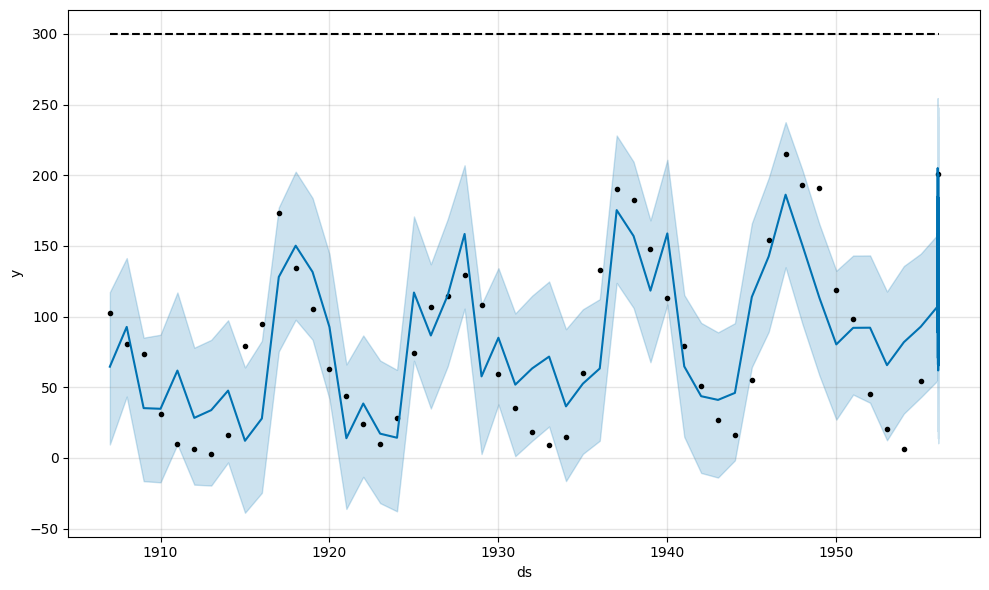

In [40]:
# plot
model.plot(forecast)
plt.show()

Here, the forecast seems to look better than it did before since it matches the actual value plotted. I am happy with how this looks, so I will continue with the last parameter to be tuned.

Trend Changepoints

In [41]:
# add cap column
df_train_subset['cap'] = 300

C:\Users\krist\AppData\Local\Temp\ipykernel_27836\1308366466.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_subset['cap'] = 300


In [42]:
# initialize model with tuning parameters
model = Prophet(
    growth='logistic',
    changepoint_prior_scale=0.5,
    n_changepoints=5)
model.add_seasonality(name='daily', period=20, fourier_order=10)

In [43]:
# fit the model
model.fit(df_train_subset)

15:19:02 - cmdstanpy - INFO - Chain [1] start processing
15:19:02 - cmdstanpy - INFO - Chain [1] done processing


In [44]:
# prepare dataframe for forecasting
future = model.make_future_dataframe(periods=20)

In [45]:
# add cap column
future['cap'] = 300

In [46]:
# make forecast
forecast = model.predict(future)

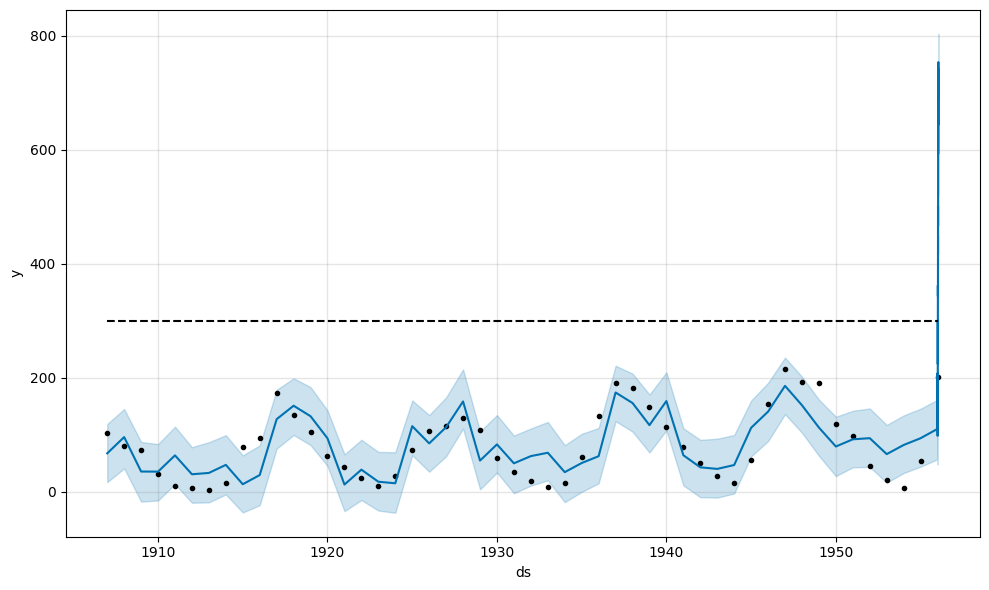

In [47]:
# plot
model.plot(forecast)
plt.show()

Once again, this graph seems to shoot up out of nowhere, but I predict that the graph will be misleading compared to the error rates.

Evaluate Model

In [49]:
# merge actual data and forecast
df_comparison = pd.merge(forecast[['ds', 'yhat']], df_prophet[['ds','y']], on='ds', how='inner')

In [50]:
# calculate MAE, MAPE, and R^2
mae = mean_absolute_error(df_comparison['y'], df_comparison['yhat'])
mape = mean_absolute_percentage_error(df_comparison['y'], df_comparison['yhat'])
r2 = r2_score(df_comparison['y'], df_comparison['yhat'])

In [51]:
print(f"MAE: {mae}")
print(f"MAPE: {mape}")
print(f"R²: {r2}")

MAE: 33.852316465335576
MAPE: 1.3212239442257117
R²: 0.5723729804542121


After playing around with the numbers in the different parameters, I decided that this combination gave me the best results. The MAE decreased by about half which is really nice to see, but the MAPE nearly doubled. Since the R^2 decreased by only a little, I was satisfied with this tradeoff. Nonetheless, I would still like to keep playing around with it in the future to see if I could get the model to fit even better.